In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import nltk
import re
nltk.download('punkt')
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import datetime
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy import sparse
import pickle

[nltk_data] Downloading package punkt to C:\Users\Tejas
[nltk_data]     Chavan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Tejas
[nltk_data]     Chavan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<p style='font-size:20px'><b> Modelling </b></p>
<p>

Applying the log-reg & lin-SVM models using the optimal hyper-param values discovered in the Grid Search CV on the old data.

</p>

In [3]:
# Load the processed, featurized train & test data 
train_x = sparse.load_npz("dataset 5L/train_x.npz")
train_y = sparse.load_npz("dataset 5L/train_y.npz")
cv_x = sparse.load_npz("dataset 5L/cv_x.npz")
cv_y = sparse.load_npz("dataset 5L/cv_y.npz")
test_x = sparse.load_npz("dataset 5L/test_x.npz")
test_y = sparse.load_npz("dataset 5L/test_y.npz")
vocab = pickle.load(open("models 5L/vocab_5L.pickle", "rb"))

In [4]:
print(train_x.shape)
print(train_y.shape)
print(cv_x.shape)
print(cv_y.shape)
print(test_x.shape)
print(test_y.shape)

(315915, 250000)
(315915, 500)
(78979, 250000)
(78979, 500)
(80883, 250000)
(80883, 500)


In [5]:
def analyse_prediction(y_actual, y_pred, num_top_tags, vocab, header):
    
    # Metrics part 1:
    # Number of tags predicted to a question, viewing the following few metrics:
    # 1. Plot: Distribution of # of tags predicted vs questions
    # 2. Plot: Distribution of difference (# of tags predicted - # of actual tags) vs questions
    # 3. Metric: Number and % of question with more than 5 predicted tags

    print('\033[1m' + "\n--------- " + header + " ---------\n" + '\033[0m')
    
    fig = plt.figure(figsize = (8,3))
    fig.subplots_adjust(wspace = 0.3)
    axs = fig.subplots(1,2)
    
    # Calculating the number of tags predicted vs number of actual tags for each question
    num_actual = np.zeros(y_actual.shape[0], dtype = 'int')
    num_pred = np.zeros(y_actual.shape[0], dtype = 'int')    
    
    non_zero_vals = y_actual.nonzero()[0]
    datapt_no, num_tags = np.unique(non_zero_vals, return_counts=True)
    num_actual[datapt_no] = num_tags
    
    non_zero_vals = y_pred.nonzero()[0]
    datapt_no, num_tags = np.unique(non_zero_vals, return_counts=True)
    num_pred[datapt_no] = num_tags
    
    
    # 1. Plot
    num_tags, num_datapts = np.unique(num_pred, return_counts=True)
    axs[0].bar(num_tags, num_datapts/1000)
    axs[0].set(xlabel = '# of tags', ylabel = '# of datapts (in thousands)', title = 'Distribution of # tags_pred vs # questions')

    # 2. Plot
    num_vals, num_datapts = np.unique(num_pred - num_actual, return_counts=True)
    axs[1].bar(num_vals, num_datapts/1000)
    axs[1].set(xlabel = 'Diff in # of tags (pred - actual)', ylabel = '# of datapts (in thousands)', title = 'Distribution of diff & # questions')
    
    # 3. Metric
    print("1a. Number & percent of datapoints having more than 5 predicted tags: {}, {}%".format(np.sum(num_pred > 5), round(100*np.sum(num_pred > 5)/y_actual.shape[0],2)))
    print("1b. Number & percent of datapoints having 0 predicted tags: {}, {}%".format(np.sum(num_pred == 0), round(100*np.sum(num_pred == 0)/y_actual.shape[0],2)))
#     print("\n2a. Number & percent of datapoints having more than 5 actual tags: {}, {}%".format(np.sum(num_actual > 5), round(100*np.sum(num_actual > 5)/y_actual.shape[0],2)))
#     print("2b. Number & percent of datapoints having 0 actual tags: {}, {}%".format(np.sum(num_actual == 0), round(100*np.sum(num_actual == 0)/y_actual.shape[0],2)))
    
    
    # Metrics part 2:
    # Label wise & Micro/Macro averaged:
    # 1. Accuracy
    # 2. Precision
    # 3. Recall
    # 4. F1 score
    
    perf_report = []
    perf_report.append(['Tag', 'Accuracy', 'Precision', 'Recall', 'F1-score'])
    
    # Getting the top number of tags
    tag_inds = np.arange(0, y_actual.shape[1], 1)
    non_zero_vals = y_actual.nonzero()[1]
    inds, count = np.unique(non_zero_vals, return_counts=True)
    sort_indices = np.argsort(count)[::-1]
    inds = inds[sort_indices]
    top_tag_inds = inds[:num_top_tags]

    for tag_ind in top_tag_inds:
        
        temp_report = []
        
        # Adding the label name in the report 
        temp_report.append(list(vocab.keys())[list(vocab.values()).index(tag_ind)])
        
        tag_actual = y_actual[:, tag_ind].toarray()
        tag_pred = y_pred[:, tag_ind].toarray()
        
        # Calculating the specified metrics
        acc = accuracy_score(tag_actual, tag_pred)
        prec = precision_score(tag_actual, tag_pred)
        rec = recall_score(tag_actual, tag_pred)
        f1_scr = f1_score(tag_actual, tag_pred)
        
        # Adding the specified metrics to the report
        temp_report = temp_report + [acc, prec, rec, f1_scr]
        
        # Adding tag metrics to the final report
        perf_report.append(temp_report)
        
        
    # Calculating the metrics at a micro-averaged level
    temp_report = []
    temp_report.append('Micro-avg')
    acc = accuracy_score(y_actual, y_pred)
    prec = precision_score(y_actual, y_pred, average = 'micro')
    rec = recall_score(y_actual, y_pred, average = 'micro')
    f1_scr = f1_score(y_actual, y_pred, average = 'micro')
    temp_report = temp_report + [acc, prec, rec, f1_scr]
    perf_report.append(temp_report)
    
    # Calculating the metrics at a macro-averaged level
    temp_report = []
    temp_report.append('Macro-avg')
    acc = accuracy_score(y_actual, y_pred)
    prec = precision_score(y_actual, y_pred, average = 'macro')
    rec = recall_score(y_actual, y_pred, average = 'macro')
    f1_scr = f1_score(y_actual, y_pred, average = 'macro')
    temp_report = temp_report + [acc, prec, rec, f1_scr]
    perf_report.append(temp_report)
    
    
    # Printing the final report
    print("\n\n2. Tag wise metrics: \n")
    col_width = 10
    print(perf_report[0][0].ljust(col_width), end = "")
    print("".join(word.center(col_width) for word in perf_report[0][1:]))
    print("------------------------------------------------")
    
    for row in perf_report[1:-2]:
        temp_tag = str(row[0])
        temp_acc = str(round(100*row[1],1)) + '%'
        temp_prec = str(round(100*row[2],1)) + '%'
        temp_rec = str(round(100*row[3],1)) + '%'
        temp_f1 = str(round(100*row[4],1)) + '%'
        
        print(temp_tag.ljust(col_width), end = "")
        print(temp_acc.center(col_width), end = "")
        print(temp_prec.center(col_width), end = "")
        print(temp_rec.center(col_width), end = "")
        print(temp_f1.center(col_width))
    
    print('\033[1m')
    for row in perf_report[-2:]:
        temp_tag = str(row[0])
        temp_acc = str(round(100*row[1],1)) + '%'
        temp_prec = str(round(100*row[2],1)) + '%'
        temp_rec = str(round(100*row[3],1)) + '%'
        temp_f1 = str(round(100*row[4],1)) + '%'
        
        print(temp_tag.ljust(col_width), end = "")
        print(temp_acc.center(col_width), end = "")
        print(temp_prec.center(col_width), end = "")
        print(temp_rec.center(col_width), end = "")
        print(temp_f1.center(col_width))
    print('\033[0m')        

<p style='font-size:18px'><b> Logistic regression </b></p>

In [16]:
start_time = datetime.datetime.now()

log_reg_clf = OneVsRestClassifier(SGDClassifier(loss='log_loss', alpha=3.25e-6, penalty='l1', max_iter = 5000))
log_reg_clf.fit(train_x, train_y)

print("Block execution time: ", datetime.datetime.now() - start_time)

Block execution time:  0:53:49.143148


In [17]:
print([estimator.n_iter_ for estimator in log_reg_clf.estimators_])

[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7, 7, 7, 7, 7, 7, 7, 6, 7, 7, 7, 7, 7, 7, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 7, 7, 8, 7, 7, 8, 7, 7, 7, 7, 7, 7, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7, 7, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 7, 7, 7, 7, 7, 7, 


--------- Log-reg (OVR): Train data ---------

1a. Number & percent of datapoints having more than 5 predicted tags: 390, 0.12%
1b. Number & percent of datapoints having 0 predicted tags: 56293, 17.82%


2. Tag wise metrics: 

Tag        Accuracy Precision   Recall   F1-score 
------------------------------------------------
c#          94.8%     74.9%     44.9%     56.1%   
java        95.9%     81.5%     57.1%     67.2%   
php         97.3%     84.8%     66.2%     74.3%   
javascript  96.6%     74.4%     51.3%     60.7%   
android     99.1%     95.0%     82.8%     88.5%   
c++         97.9%     82.6%     58.9%     68.8%   
jquery      98.3%     85.3%     66.9%     75.0%   
python      98.9%     89.1%     70.5%     78.7%   
iphone      98.0%     72.4%     46.3%     56.4%   
.net        97.5%     64.7%     16.5%     26.3%   

Micro-avg   16.3%     77.0%     45.7%     57.3%   
Macro-avg   16.3%     72.6%     44.6%     53.8%   


Block execution time:  0:02:12.980877


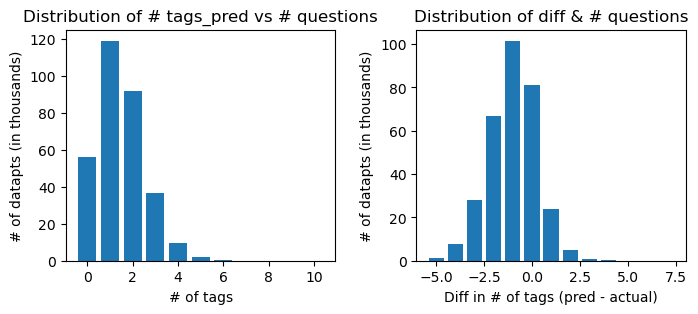

In [18]:
start_time = datetime.datetime.now()

# Predict the tags using the model trained above
y_pred_train = log_reg_clf.predict(train_x)

# Generate performance report
analyse_prediction(train_y, y_pred_train, 10, vocab, "Log-reg (OVR): Train data")

print("\nBlock execution time: ", datetime.datetime.now() - start_time)


--------- Log-reg (OVR): Test data ---------

1a. Number & percent of datapoints having more than 5 predicted tags: 156, 0.19%
1b. Number & percent of datapoints having 0 predicted tags: 14568, 18.01%


2. Tag wise metrics: 

Tag        Accuracy Precision   Recall   F1-score 
------------------------------------------------
c#          94.5%     69.3%     43.9%     53.8%   
java        95.6%     78.2%     53.3%     63.4%   
php         97.1%     83.3%     65.8%     73.5%   
javascript  96.4%     70.1%     49.8%     58.2%   
android     99.0%     94.2%     81.9%     87.6%   
jquery      98.1%     85.4%     64.9%     73.7%   
c++         97.9%     81.4%     57.5%     67.4%   
iphone      97.8%     70.2%     45.5%     55.2%   
python      98.8%     87.2%     68.2%     76.5%   
.net        97.4%     57.6%     14.7%     23.4%   

Micro-avg   14.5%     73.6%     44.3%     55.3%   
Macro-avg   14.5%     68.9%     43.3%     51.9%   


Block execution time:  0:00:33.568912


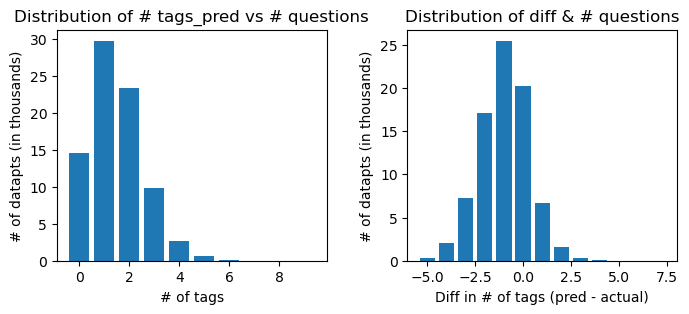

In [19]:
start_time = datetime.datetime.now()

# Predict the tags using the model trained above
y_pred_test = log_reg_clf.predict(test_x)

# Generate performance report
analyse_prediction(test_y, y_pred_test, 10, vocab, "Log-reg (OVR): Test data")

print("\nBlock execution time: ", datetime.datetime.now() - start_time)

<p style='font-size:18px'><b> Linear SVM </b></p>

In [20]:
start_time = datetime.datetime.now()

lin_svm_clf = OneVsRestClassifier(SGDClassifier(loss='hinge', alpha=5.5e-6, penalty='l1', max_iter = 5000))
lin_svm_clf.fit(train_x, train_y)

print("Block execution time: ", datetime.datetime.now() - start_time)

Block execution time:  0:33:58.856317


In [21]:
print([estimator.n_iter_ for estimator in lin_svm_clf.estimators_])

[7, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 10, 7, 9, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 7, 7, 7, 7, 7, 7, 9, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7, 8, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 7, 7, 7, 7, 8, 7, 7, 9, 7, 7, 8, 7, 7, 7, 7, 7, 7, 6, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7, 7, 7, 7, 7, 7, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7, 7, 7, 7, 7, 7, 7, 6, 7, 7, 7, 7, 7, 7, 8, 7, 7, 7, 7, 6, 7, 7, 7, 7, 7, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 7, 7, 7, 8, 7, 7, 7, 7, 7, 7,


--------- Lin-SVM (OVR): Train data ---------

1a. Number & percent of datapoints having more than 5 predicted tags: 21, 0.01%
1b. Number & percent of datapoints having 0 predicted tags: 65225, 20.65%


D:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))




2. Tag wise metrics: 

Tag        Accuracy Precision   Recall   F1-score 
------------------------------------------------
c#          94.8%     77.2%     43.9%     56.0%   
java        95.8%     83.8%     53.7%     65.4%   
php         97.3%     86.5%     64.7%     74.0%   
javascript  96.6%     83.2%     40.4%     54.4%   
android     99.1%     95.7%     81.9%     88.2%   
c++         97.9%     88.3%     52.6%     65.9%   
jquery      98.3%     86.4%     65.4%     74.5%   
python      98.9%     89.4%     73.0%     80.3%   
iphone      97.9%     80.8%     36.4%     50.1%   
.net        97.4%     72.4%      9.2%     16.3%   

Micro-avg   15.8%     82.4%     41.0%     54.7%   
Macro-avg   15.8%     76.4%     40.2%     47.3%   


Block execution time:  0:02:11.470280


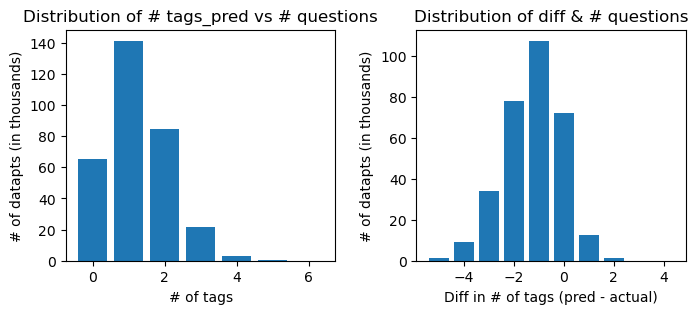

In [22]:
start_time = datetime.datetime.now()

# Predict the tags using the model trained above
y_pred_train = lin_svm_clf.predict(train_x)

# Generate performance report
analyse_prediction(train_y, y_pred_train, 10, vocab, "Lin-SVM (OVR): Train data")

print("\nBlock execution time: ", datetime.datetime.now() - start_time)


--------- Lin-SVM (OVR): Test data ---------

1a. Number & percent of datapoints having more than 5 predicted tags: 5, 0.01%
1b. Number & percent of datapoints having 0 predicted tags: 16900, 20.89%


D:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))




2. Tag wise metrics: 

Tag        Accuracy Precision   Recall   F1-score 
------------------------------------------------
c#          94.7%     72.8%     42.9%     54.0%   
java        95.6%     81.5%     50.8%     62.6%   
php         97.1%     85.1%     65.0%     73.7%   
javascript  96.4%     80.1%     39.6%     53.0%   
android     99.0%     95.0%     80.2%     87.0%   
jquery      98.2%     87.5%     64.1%     74.0%   
c++         97.9%     88.5%     51.4%     65.0%   
iphone      97.8%     80.4%     36.0%     49.7%   
python      98.9%     87.7%     71.1%     78.5%   
.net        97.4%     70.2%      9.0%     15.9%   

Micro-avg   14.7%     80.7%     40.1%     53.5%   
Macro-avg   14.7%     69.1%     39.3%     46.0%   


Block execution time:  0:00:33.437025


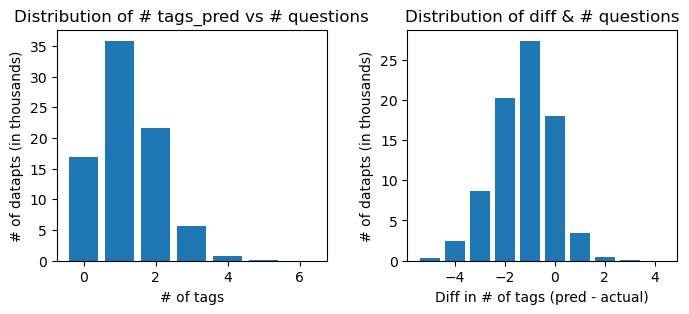

In [23]:
start_time = datetime.datetime.now()

# Predict the tags using the model trained above
y_pred_test = lin_svm_clf.predict(test_x)

# Generate performance report
analyse_prediction(test_y, y_pred_test, 10, vocab, "Lin-SVM (OVR): Test data")

print("\nBlock execution time: ", datetime.datetime.now() - start_time)

<p style='font-size:18px'><b> Conclusion </b></p>

<p>

Compared to the old data the Macro-avg F1 score has increased significantly to 51.9% on test data (Log-reg model), while still maintaining a Micro-avg F1-score of 55.3%.

</p>
